## Introducrion
This notebook walktroughs the basics of graph segmentation and motivates some track building algorithms such as connected components (CC) and connected components and junction removal (CCandJR).

## Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [ ]:
import torch
import os
import numpy as np
import pandas as pd
from torch_geometric.utils import to_scipy_sparse_matrix
from scipy.sparse.csgraph import connected_components
from matplotlib import collections  as mc
import matplotlib.pyplot as plt
import networkx as nx

# Local imports
from acorn.stages.track_building.utils import evaluate_labelled_graph
from acorn.stages.track_building.models.cc_and_walk_utils import remove_cycles

GRAPH_DIR = "/global/cfs/cdirs/m2616/pmtuan/inferred_data/igcn_14999421_epoch66_redo/testset/"

## Load GNN-labeled Event and Define Hyperparameters

In [3]:
events = []
for path in os.listdir(GRAPH_DIR):
    events.append(torch.load(os.path.join(GRAPH_DIR, path)))
    if len(events) > 10:
        break
print(events[0])

DataBatch(x=[325099], edge_index=[2, 1080166], y=[1080166], z=[325099], module_id=[325099], cluster_z_2=[325099], lengthDir2_2=[325099], lengthDir1_2=[325099], localDir0_1=[325099], glob_phi_2=[325099], cluster_x_1=[325099], glob_phi_1=[325099], charge_count_2=[325099], norm_z_2=[325099], phi_angle_1=[325099], hit_id=[325099], eta_angle_2=[325099], norm_z_1=[325099], cluster_phi_1=[325099], lengthDir0_2=[325099], cluster_eta_1=[325099], cluster_r_1=[325099], cluster_y_2=[325099], eta=[325099], loc_phi_2=[325099], cluster_phi_2=[325099], loc_eta_2=[325099], cluster_eta_2=[325099], r=[325099], eta_angle_1=[325099], norm_x_1=[325099], lengthDir1_1=[325099], phi=[325099], cluster_y_1=[325099], charge_count_1=[325099], region=[325099], localDir2_2=[325099], glob_eta_1=[325099], cluster_x_2=[325099], phi_angle_2=[325099], norm_y_1=[325099], loc_phi_1=[325099], localDir0_2=[325099], cluster_r_2=[325099], count_2=[325099], cluster_z_1=[325099], lengthDir0_1=[325099], lengthDir2_1=[325099], loc

We need to define the hyperparameters to use in inference and evaluation. The parameters are the following:
- cc_hparams
    - `score_cut`: the score cut used to remove fake edges
- cc_and_jr_hparams
    - `score_cut`: the score cut used to select chain-like edges
    - `junction_cut`: the score cut above which junctions will be removed and segments will be selected
- eval_hparams
    - `matching_fraction`: the matching fraction used by the matching style
    - `matching_style`: can be one of `one_way`, `one_way`, or `ATLAS`. Will be defined in details later.
    - `min_track_length`: the minimum track length where tracks with fewer hits will not be considered.
    - `target_tracks`: A dictionary of keys:
        - `pt`: a tuple of lower and upper limit of $p_T$ in $GeV$ to consider when evaluating tracking performance
        - `n_true_hits`: a tuple of lower and upper limit of number of true hits recorded to consider when evaluating tracking performance
        - `primary`: `True` to include only primary particles, `False` otherwise 
        - `pdgId`: tuple to select particle types to consider with PDG IDs.
        - `radius`: the vertex radius in $mm$.
        - `eta_particle`: a tuple of lower and upper limit of $\eta$ to consider when evaluating tracking performance

In [4]:
cc_hparams = {
    "score_cut": 0.9,
}
cc_and_jr_hparams = {
    "score_cut": 0.9,
    "junction_cut": 0.2,
    "min_chain_length": 5
}
eval_hparams = {
    "matching_fraction": 0.5,
    "matching_style": "ATLAS",
    "min_track_length": 5,
    "target_tracks": {
        "pt": [1000, float("inf")],
        "n_true_hits": [7, float("inf")],
        "primary": True, 
        "pdgId": ["not_in", [11, -11]],
        "radius": [0., 260.],
        "eta_particle": [-4., 4.],
    }
}

## Connected Components

Now, we need to build the tracks from the GNN scores. The simplest algorithm one can think of is a connected components algorithm, which is to build a track by first applying a score cut, filtering out the unlikely edges and selecting all components as track candidates.

In [5]:
def build_tracks(event):
    # Select high score edges
    edge_mask = (event.scores > cc_hparams["score_cut"])

    # Convert to sparse scipy array
    sparse_edges = to_scipy_sparse_matrix(
        event.edge_index[:, edge_mask], num_nodes=event.x.shape[0]
    )

    # Run connected components
    _, candidate_labels = connected_components(
        sparse_edges, directed=False, return_labels=True
    )

    # Compute the size of the connected components
    _, inverse, counts = np.unique(
        candidate_labels, return_counts=True, return_inverse=True
    )

    # Filter out any track candidate that has only one hit
    candidate_labels[counts[inverse] <= 1] = -1

    # Record the labels
    event.labels = torch.from_numpy(candidate_labels).long()
    
for event in events:
    build_tracks(event)

Then, we evaluate the tracking performance by passing the labeled event into the `evaluate_labelled_graph`. The idea of this function is to calculate the **purity** and the **efficiency** of a track candidate with respect to a particle. The *purity* is defined as the fraction of the hits coming from a particle in a track candidate, in other words, how pure the track candidate is. The *efficiency* is defined as the fraction of hits in a particle being included in a specific track candidate, in other words, how efficient the track candidate is in capturing the hits from a specific particle.

The **one_way** matching is defined as: a particle is reconstructed by a track candidate if efficiency is greater or equals to matching fraction. A track candidate is matched to a particle if purity is greater or equals to matching fraction.

The **two_way** matching is defined as: a particle is reconstructed by a track candidate and a track candidate is matched to a particle if the efficiency and purity are both greater or equals to matching fraction.

The **ATLAS** matching is defined as: a particle is reconstructed by a track candidate and a track candidate is matched to a particle if the purity is greater or equals to matching fraction.

In [6]:
# The matching_df contains necessary information about the particle and the efficiency/purity of the track candidates with repect to the particle. 
all_dfs = []
for i, event in enumerate(events):
    matching_df = evaluate_labelled_graph(
        event, 
        matching_fraction=eval_hparams["matching_fraction"],
        matching_style=eval_hparams["matching_style"],
        sel_conf=eval_hparams["target_tracks"],
        min_track_length=eval_hparams["min_track_length"],
    )
    matching_df["event_index"] = i
    all_dfs.append(matching_df)
all_dfs = pd.concat(all_dfs)

We can then proceed to evaluating the evaluation of the entire event. There are three important metrics:
- tracking efficiency: the fraction of target tracks selected by `target_tracks` that is at least reconstructed by a track candidate under the specified matching style and fraction.
- fake rate: the fraction of track candidates that is not reconstructing any particle, regarless if they are target tracks
- duplicate rate: the fraction of reconstructed particles that is reconstructed by more than one track candidate. 

In [7]:
def get_statistics(matching_df):
    # particles are the target tracks.
    particles = matching_df[matching_df["is_reconstructable"]]
    # reconstructed ones must be matchable at the first place 
    reconstructed_particles = particles[
        particles["is_reconstructed"] & particles["is_matchable"]
    ]

    # filter true tracks, excluding the ones that are not matchable
    tracks = matching_df[matching_df["is_matchable"]]
    # select matched track candidates
    matched_tracks = tracks[tracks["is_matched"]]

    # denominator of tracking efficiency
    n_particles = len(particles.drop_duplicates(subset=["event_id", "particle_id"]))
    # numerator of tracking efficiency
    n_reconstructed_particles = len(
        reconstructed_particles.drop_duplicates(subset=["event_id", "particle_id"])
    )

    # denominator of fake rate
    n_tracks = len(tracks.drop_duplicates(subset=["event_id", "track_id"]))
    # numerator of TRUE rate
    n_matched_tracks = len(
        matched_tracks.drop_duplicates(subset=["event_id", "track_id"])
    )

    # numerator of duplicate rate
    n_dup_reconstructed_particles = (
        len(reconstructed_particles) - n_reconstructed_particles
    )

    eff = n_reconstructed_particles / n_particles
    fake_rate = 1 - (n_matched_tracks / n_tracks)
    dup_rate = n_dup_reconstructed_particles / n_reconstructed_particles
    print(f"Tracking efficiency: {eff:.3f}\nFake rate: {fake_rate:.3f}\nDuplicate rate: {dup_rate:.3f}")

In [8]:
get_statistics(all_dfs)

Tracking efficiency: 0.991
Fake rate: 0.001
Duplicate rate: 0.015


## Disgnose Failing Cases

The tracking efficiency we just got is pretty good! However, one might wonder is there an even better way. To answer to this question, we must first take a deeper look into the track candidates we just generated and build a solid understanding of the failing patterns of our simple connected components algorithm. We should start by examine the topology of the not matched tracks:

In [9]:
not_matched_tracks = all_dfs[~all_dfs["is_matched"] & all_dfs["is_reconstructable"] & all_dfs["is_matchable"]][["event_index", "track_id"]].drop_duplicates()
not_matched_tracks = not_matched_tracks.dropna()[not_matched_tracks["track_id"] != -1]
print(not_matched_tracks.size)

86


We want to understand the tracks in a more intuitive way. To achieve this, we plot out the shape of the tracks in both x-y coordinates and spring layout (force directed algorithm). The latter one can help us to get a better sense of what the topology is since x-y coordinate can be hard to read if the nodes are too close.

In [10]:
def plot_tracks(events, use_spring_layout=False):
    fig, (axs) = plt.subplots(ncols=3, nrows=2, figsize=(12, 6))
    axs = [ax for axss in axs for ax in axss]
    for (event_id, track_id), ax in zip(not_matched_tracks.sample(n=6, random_state=42).values, axs):
        event = events[event_id]
        hits = torch.arange(event.labels.shape[0])[event.labels == track_id]

        edge_mask = (event.scores > cc_hparams["score_cut"]) & torch.isin(event.edge_index, hits).all(0)
        edges = event.edge_index[:, edge_mask]

        track_edge_mask = torch.isin(event.track_edges, hits).all(0)
        pids = event.particle_id[track_edge_mask]
        _, pids = pids.unique(return_inverse=True)
        track_edges = event.track_edges[:, track_edge_mask].T
        pid_mapping = {tuple(track_edge.tolist()): pid.item() for pid, track_edge in zip(pids, track_edges)}
        if use_spring_layout:
            G = nx.Graph()
            G.add_nodes_from(hits.tolist())
            G.add_edges_from(edges.T.tolist())
            pos = nx.spring_layout(G)
            lines = [[pos[edge[0].item()], pos[edge[1].item()]] for edge in edges.T]
        else:
            x, y = event.r * torch.cos(event.phi), event.r * torch.sin(event.phi)
            lines = [[[x[edge[0]], y[edge[0]]], [x[edge[1]], y[edge[1]]]] for edge in edges.T]
        colors = [plt.rcParams['axes.prop_cycle'].by_key()['color'][pid_mapping.get(tuple(edge.tolist()), -1) + 1] for edge in edges.T]
        lc = mc.LineCollection(lines, linewidths=1, colors = colors)
        ax.add_collection(lc)
        ax.margins(0.1)
    plt.show()

In the following plots, the fake edges are labeled blue and the true edges are colored differently depending on their PIDs. It is clear that sometimes even though the GNN does a perfect job figuring out the true and fake edges, we still cannot split the tracks due to the existance of genuine shared hits. We can call the case where two particles are clustered into the same track as "merged tracks"

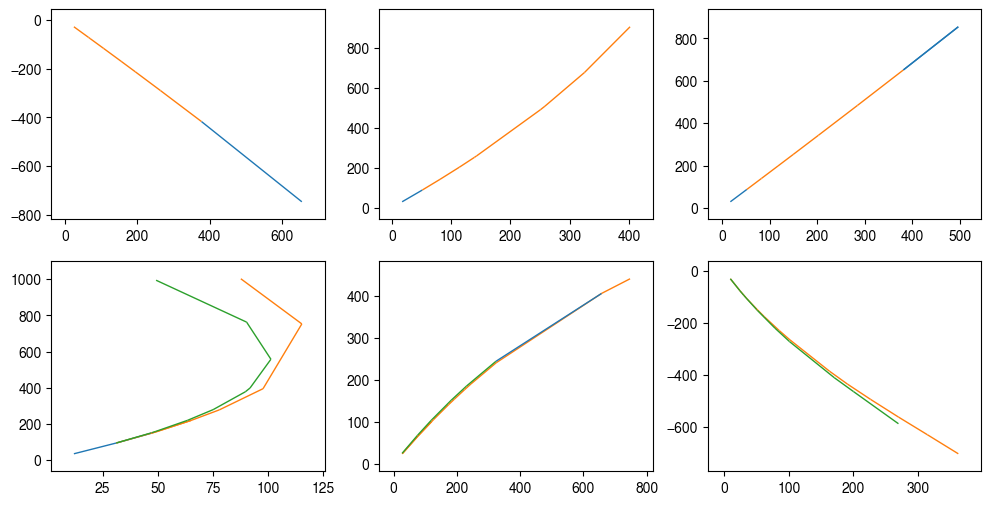

In [11]:
plot_tracks(events, use_spring_layout=False)

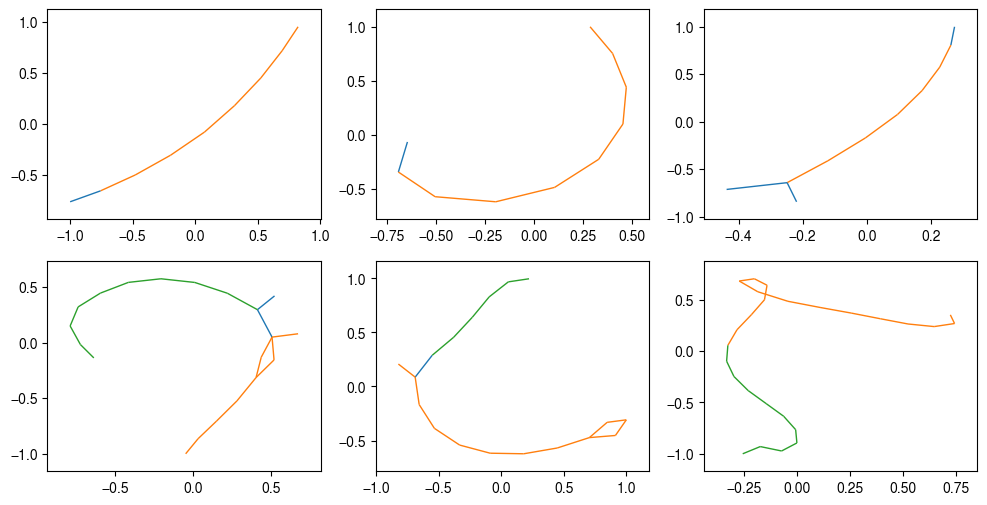

In [12]:
plot_tracks(events, use_spring_layout=True)

## Heuristic-based Connected Components: Junction Removal

With the picture in mind, how can we do better? One possible solution is to use what I called the Junction Removal model. The idea is simple. We first make the graph directed by requiring $r = \sqrt{x^2+y^2}$ to be increasing for all edges. Then, we apply a score cut and select all "chain-like" tracks whose in- and out-degree are less or equal to one. This essentially removes the upper left and lower three tracks from consideration since they have "junctions" with in or out degree greater than one. After this, we apply another score cut, the `junction_cut`, then remove any hit that has in or out degree greater or equal to one. Then we run connected components to select the track candidates. The idea is that by disconnecting all "junctions," we can break the merged tracks and therefore find some more tracks.

In [13]:
def build_tracks(event):
    event = remove_cycles(event)
    # Initialize the array to track which hit to keep
    to_keep = torch.ones_like(event.hit_id, dtype=torch.bool)

    # Select good tracks with at least `min_hits` hits
    if cc_and_jr_hparams["score_cut"]:
        # run cc
        chain_edges = event.edge_index[
            :, (event.scores > cc_and_jr_hparams["score_cut"])
        ]
        graph = to_scipy_sparse_matrix(
            chain_edges, num_nodes=event.hit_id.shape[0]
        ).tocsr()
        _, track_id = connected_components(graph, directed=False)

        # remove short tracks
        _, inverse, nhits = np.unique(
            track_id, return_counts=True, return_inverse=True
        )
        track_id[nhits[inverse] < cc_and_jr_hparams["min_chain_length"]] = -1

        # remove any not simple tracks
        out_hit_id, out_degree = np.unique(
            chain_edges[0], return_counts=True, return_inverse=False
        )
        in_hit_id, in_degree = np.unique(
            chain_edges[1], return_counts=True, return_inverse=False
        )
        track_id[np.isin(track_id, track_id[in_hit_id[in_degree > 1]])] = -1
        track_id[np.isin(track_id, track_id[out_hit_id[out_degree > 1]])] = -1

        # store the good tracks and update tracker
        track_id = torch.as_tensor(track_id, dtype=torch.long)
        to_keep[track_id >= 0] = False

    # perform clustering
    if cc_and_jr_hparams["junction_cut"]:
        # Apply the score cut
        junction_edges = event.edge_index[
            :, (event.scores > cc_and_jr_hparams["junction_cut"])
        ]
        junction_edges = junction_edges[:, to_keep[junction_edges].all(0)]

        # Compute in and out degrees
        out_hit_id, out_degree = torch.unique(
            junction_edges[0], return_counts=True, return_inverse=False
        )
        in_hit_id, in_degree = torch.unique(
            junction_edges[1], return_counts=True, return_inverse=False
        )

        # Masking out the junctions
        mask = torch.isin(
            junction_edges[0], out_hit_id[out_degree <= 1]
        ) | torch.isin(junction_edges[1], out_hit_id[out_degree <= 1])
        junction_edges = junction_edges[:, mask]

        # build csr graph and run cc
        graph = to_scipy_sparse_matrix(
            junction_edges, num_nodes=event.x.shape[0]
        )
        _, labels = connected_components(graph, directed=False)
        labels = torch.as_tensor(labels, dtype=torch.long)
        _, inverse, counts = torch.unique(
            labels, return_counts=True, return_inverse=True
        )
        track_id[to_keep & (counts[inverse] > 1)] = (
            labels[to_keep & (counts[inverse] > 1)] + track_id.max() + 1
        )

    event.labels = track_id
    
for event in events:
    build_tracks(event)

We then proceed to evaluate this method:

In [14]:
# The matching_df contains necessary information about the particle and the efficiency/purity of the track candidates with repect to the particle. 
all_dfs = []
for i, event in enumerate(events):
    matching_df = evaluate_labelled_graph(
        event, 
        matching_fraction=eval_hparams["matching_fraction"],
        matching_style=eval_hparams["matching_style"],
        sel_conf=eval_hparams["target_tracks"],
        min_track_length=eval_hparams["min_track_length"],
    )
    matching_df["event_index"] = i
    all_dfs.append(matching_df)
all_dfs = pd.concat(all_dfs)
get_statistics(all_dfs)

Tracking efficiency: 0.995
Fake rate: 0.006
Duplicate rate: 0.028


Indeed, we gain some free efficiencies!

To validate if this method does the job of breaking the merged tracks, we can run the same diagnosis again:

200


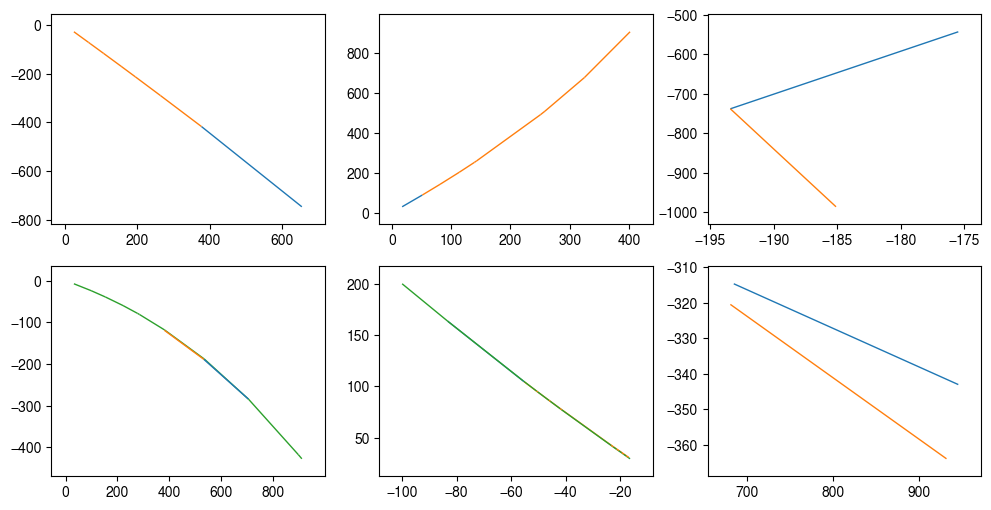

In [15]:
not_matched_tracks = all_dfs[~all_dfs["is_matched"] & all_dfs["is_reconstructable"] & all_dfs["is_matchable"]][["event_index", "track_id"]].drop_duplicates()
not_matched_tracks = not_matched_tracks.dropna()[not_matched_tracks["track_id"] != -1]
print(not_matched_tracks.size)
plot_tracks(events, use_spring_layout=False)